In [1]:
import shutil
import numpy as np
import matplotlib.pyplot as plt

from pyiron import Project
import pyiron_contrib
import pyiron
import pyiron_base
import h5py
from copy import deepcopy

### Check paths and versions

In [2]:
print(pyiron.__file__)
print(pyiron_base.__file__)
print(pyiron_contrib.__file__)

/u/caras/pyiron_repos/pyiron/pyiron/__init__.py
/u/caras/pyiron_repos/pyiron_base/pyiron_base/__init__.py
/u/caras/pyiron_repos/pyiron_contrib/pyiron_contrib/__init__.py


In [3]:
print(pyiron.__version__)
print(h5py.__version__)

0.3.17
3.1.0


In [4]:
pr = Project('TI_test_Ti1500K')
pr.remove_jobs(recursive=True)
pr.get_repository_status() 

Are you sure you want to delete all jobs from 'TI_test_Ti1300K'? y/(n)y


,Module,Git head
0,pyiron_base,862be30490fda1b94b2e83788aa7c5ed45bf7d4d
1,pyiron,d410e585babd3b07326853de38134bd182b528bd
2,pyiron_contrib,783f52634780db0daac40b9bcba1d7ae2a06b683
3,pyiron_mpie,36862f9f1e51a13e818495f4354c4defb88d63ac


In [5]:
# inputs

# structure
element = 'Ti'
crystal_structure = 'bcc'
supercell = 4
potential = '1992--Ackland-G-J--Ti--LAMMPS--ipr1'

# MD specific
a = 3.25  
temperature = 1500.
time_step = 1  # MD timestep
n_steps = 50000  # MD steps
sampling_period = 10  # same as `n_print` from calc_md
thermalization_steps = 2000  # number of steps to equilibriate the system for
temperature_damping_timescale = 100.  # same as the one from calc_md 
convergence_steps = 25000  # number of steps after which to check for convergence
fe_tol = 1e-3  # convergence criterion 1meV 

# integration specific
n_lambdas = 30

# cluster specific
phon_cores = 4
phon_run_time = 1800  # in seconds
tild_cores = n_lambdas  # if running on the headnode, use 1! Otherwise, set to n_lambdas
queue = 'cmti'
tild_run_time = 24400  # in seconds

In [6]:
# structures with the expanded lattice

pr_zero = pr.create_group('ionic_relaxation')

bulk = pr_zero.create_job(pr.job_type.Lammps, 'bulk')
bulk.structure = pr.create_ase_bulk(name=element, crystalstructure=crystal_structure, a=a,
                                    cubic=True).repeat(supercell)
n_atoms = len(bulk.structure.positions)
bulk.potential = potential
bulk.calc_minimize(pressure=None)  # we keep the volume constant! (because we obtained the lattice constant from MD)
bulk.run()

The job bulk was saved and received the ID: 10738969


In [7]:
bulk['output/generic/energy_pot']/128

array([-4.80657667, -4.80657667])

In [ ]:
# show potentials
bulk.list_potentials()

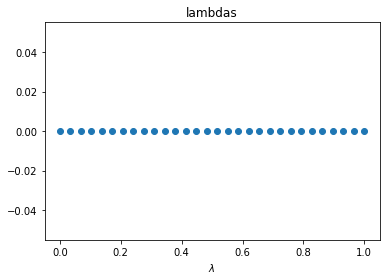

In [8]:
# generate and plot lambdas (integration_points)

def generate_lambdas(N, bias=0.5):
    """
    A function to generate N points between 0 and 1, with a left, equidistant and right bias.
    bias = 0 makes the points fully left biased. The amount of left bias can be controlled by varying it between 0 and 
        0.49.
    bias = 0.5 keeps the points equidistant.
    bias = 1 makes the points fully right biased. The amount of right bias can be controlled by varying it between 0.51 
        and 1.
    
    """
    factor = bias + 0.5
    lambdas = [0, 1]
    for n in np.arange(N - 2):
        lambdas.append(lambdas[-1] + (lambdas[-1] - lambdas[-2]) / factor)
    lambdas = np.asarray(lambdas)
    lambdas /= lambdas[-1]
    
    return np.around(lambdas, decimals=4)
# we use equidistant bias in new_generate_lambdas
lambdas = generate_lambdas(n_lambdas, bias=0.5)

plt.title('lambdas')
plt.scatter(lambdas, np.zeros(n_lambdas))
plt.xlabel('$\lambda$')
plt.show()

In [10]:
# setup phonopy jobs
# There will be two of them.
#1 for pos def
#1 for neglected negative frequencies

pr_phon = pr.create_group('phonons')

phon_ref_job = pr_phon.create_job(pr.job_type.Lammps, 'phon_ref')
phon_ref_job.structure = bulk.get_structure()
phon_ref_job.potential = potential

phonopy_job = phon_ref_job.create_job(pr.job_type.PhonopyJob,'phonopy_job')
phonopy_job.input['primitive_matrix'] = 'auto'
phonopy_job.server.cores = phon_cores
#phonopy_job.server.queue = queue
phonopy_job.server.run_time = phon_run_time
phonopy_job.run()

The job phonopy_job was saved and received the ID: 10738981
The job phon_ref_0 was saved and received the ID: 10738984


A_qh_normal(posdef): [-0.6950397] eV/atom
A_qh_anormal: [-0.70214639] eV/atom


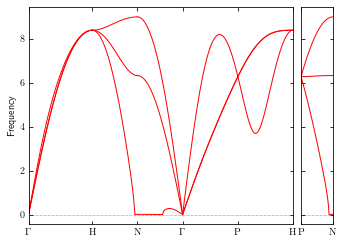

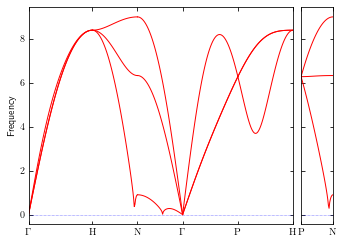

In [11]:
# load phonopy jobs, in case you ran this on the cluster    
from mylib import get_fc_from_pos_dyn_matrices
phon_path = Project(pr_phon.path)
phonopy_job = phon_path.load('phonopy_job')

phonopy_normal = phonopy_job.phonopy
phonopy_normal.positivedefdyn = True
phonopy_normal._set_dynamical_matrix()

phonopy_anormal = deepcopy(phonopy_normal)
phonopy_anormal.positivedefdyn = '1'
phonopy_anormal._set_dynamical_matrix()

phonopy_anormal.auto_band_structure(plot=True)
phonopy_anormal.auto_total_dos(plot=False)
phonopy_anormal.run_thermal_properties(temperatures=temperature)

phonopy_normal.auto_band_structure(plot=True)
phonopy_normal.auto_total_dos(plot=False)
phonopy_normal.run_thermal_properties(temperatures=temperature)

# get force constants
force_constants_normal = get_fc_from_pos_dyn_matrices(phonopy_normal)
force_constants_anormal = get_fc_from_pos_dyn_matrices(phonopy_anormal)

at_nu_prim = phonopy_normal.primitive.get_number_of_atoms()

# extract qh free energies
A_qh_normal = phonopy_normal.get_thermal_properties_dict()['free_energy']/at_nu_prim*0.01036410 #kjmol to ev
A_qh_anormal = phonopy_anormal.get_thermal_properties_dict()['free_energy']/at_nu_prim*0.01036410 #kjmol to ev

print('A_qh_normal(posdef): {} eV/atom'.format(A_qh_normal  ))
print('A_qh_anormal: {} eV/atom'.format(A_qh_anormal  ))


(array([ 5376.,   768., 12288., 12288.,  7936., 78080.,     0., 24576.,
            0.,  6144.]),
 array([-0.00293007, -0.00238891, -0.00184774, -0.00130658, -0.00076542,
        -0.00022426,  0.00031691,  0.00085807,  0.00139923,  0.00194039,
         0.00248156]),
 <BarContainer object of 10 artists>)

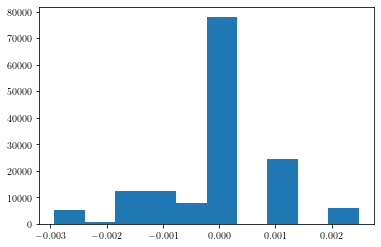

In [12]:
plt.hist((force_constants_anormal - force_constants_normal).reshape(-1))

In [13]:
force_constants_anormal.shape

(128, 128, 3, 3)

## Not automatic create jobs one by one.

In [15]:
pr_tild = pr.create_group('tild_jobs_anormal') ######### NAME
pr_tild.remove_jobs_silently(recursive=True)

# run the TILD protocol
tild_ref_job = pr_tild.create_job(pr.job_type.Lammps, 'ref_job')
tild_ref_job.potential = potential
tild_ref_job.structure = bulk.get_structure()
tild_ref_job.save()

job = pr_tild.create_job(pr.job_type.ProtocolHarmonicTILDParallel, 'job')
job.input.structure = bulk.get_structure()
job.input.temperature = temperature
job.input.ref_job_full_path = tild_ref_job.path
job.input.spring_constant = None
job.input.force_constants = force_constants_anormal ######### FORCE CONSTANTS
job.input.temperature_damping_timescale = temperature_damping_timescale
job.input.n_lambdas = n_lambdas
job.input.sampling_period = sampling_period
job.input.thermalization_steps = thermalization_steps
job.input.convergence_check_steps = convergence_steps
job.input.fe_tol = fe_tol
job.input.custom_lambdas = lambdas
job.input.n_steps = n_steps


# sleep-time, set this only if you're running this on your local PC
#job.input.sleep_time = 0.05

# cluster inputs
job.server.cores = tild_cores
job.server.queue = queue
job.server.run_time = tild_run_time

# run_job
job.run()

The job ref_job was saved and received the ID: 10739046
The job job was saved and received the ID: 10739049
Queue system id:  1592942


In [ ]:
pr['tild_jobs_normal/job/output']

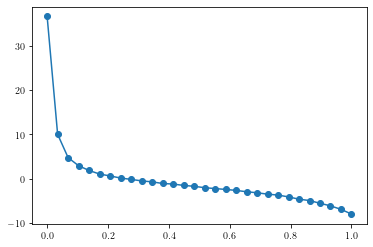

In [18]:
plt.plot(lambdas, pr['tild_jobs_normal/job/output/integrands/i_0'], marker='o')

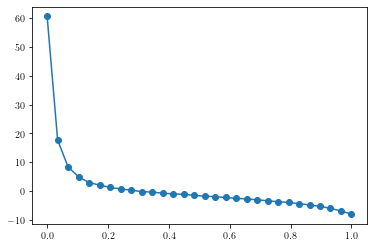

In [21]:
plt.plot(lambdas, pr['tild_jobs_anormal/job/output/integrands/i_0'], marker='o')

In [28]:
pr['tild_jobs_anormal/job/output/tild_free_energy_std'] / n_atoms

array([0.00344398])

In [27]:
pr['tild_jobs_anormal/job/output/tild_free_energy_se'] / n_atoms

array([4.9704329e-05])

In [29]:
A_tild_normal = pr['tild_jobs_normal/job/output/tild_free_energy_mean'][-1] / n_atoms
A_tild_anormal = pr['tild_jobs_anormal/job/output/tild_free_energy_mean'][-1] / n_atoms

print('integral_uppercase: {} eV/atom'.format(A_tild_anormal)) 
print('A_harmonic_uppercase: {} eV/atom'.format(A_qh_anormal  )) # This is already per atom!!!
del_A_tild_anormal = A_qh_anormal + A_tild_anormal
print('total_A_uppercase: {} eV/atom'.format(del_A_tild_anormal ))
print('*-*-*-*-*-*-')
print('integral_lowercase: {} eV/atom'.format(A_tild_normal)) 
print('A_harmonic_lowercase: {} eV/atom'.format(A_qh_normal  )) # This is already per atom!!!
del_A_tild_normal = A_qh_normal + A_tild_normal
print('total_A_lowercase: {} eV/atom'.format(del_A_tild_normal ))

integral_uppercase: 0.0009955021829099716 eV/atom
A_harmonic_uppercase: [-0.70214639] eV/atom
total_A_uppercase: [-0.70115089] eV/atom
*-*-*-*-*-*-
integral_lowercase: -0.007791189737652962 eV/atom
A_harmonic_lowercase: [-0.6950397] eV/atom
total_A_lowercase: [-0.70283089] eV/atom


## Notebook ends here.

In [ ]:
total_steps = pr_tild['job/output/total_steps/i_0']
temperature_mean = pr_tild['job/output/temperature_mean/i_0']
temperature_std = pr_tild['job/output/temperature_std/i_0']
integrands = pr_tild['job/output/integrands/i_0']
integrands_std = pr_tild['job/output/integrands_std/i_0']
integrands_n_samples = (pr_tild['job/output/integrands_n_samples/i_0'])
A_tild = pr_tild['job/output/tild_free_energy_mean'][-1]  # A, because this is technically the Helmholtz free energy
A_tild_std = pr_tild['job/output/tild_free_energy_std'][-1]
A_tild_se = pr_tild['job/output/tild_free_energy_se'][-1]
A_fep = pr_tild['job/output/fep_free_energy_mean'][-1]  # we also get A from the free energy perturbation method
A_fep_std = pr_tild['job/output/fep_free_energy_std'][-1]
A_fep_se = pr_tild['job/output/fep_free_energy_se'][-1]

In [ ]:
print('mean temperature: {} K'.format(np.mean(temperature_mean)))
print('A_tild: {} meV/atom'.format(A_tild * 1e3 / n_atoms))  # * 1e3 to convert it to meV
print('A_fep: {} meV/atom'.format(A_fep * 1e3 / n_atoms))
print('A_qh: {} meV/atom'.format(A_qh * 1e3 / n_atoms))
# total contribution to free energy of the system at this temperature, including the purely harmonic part
# add to A_qh the TILD/FEP free energies we computed to get the anharmonic free energy of the system
del_A_tild = A_qh + A_tild
del_A_fep = A_qh + A_fep
print('del_A_tild: {} meV/atom'.format(del_A_tild * 1e3 / n_atoms))
print('del_A_fep: {} meV/atom'.format(del_A_fep * 1e3 / n_atoms))

In [ ]:
pr_tild['job/output/integrands_std/i_0']